In [1]:
# import all the important packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

# Question One

Consider the data set redwine-binary.csv. This data contains both objective measurements on chemical and physical properties of the red wines, and subjective measurements of quality based on expert judegments. In this data, wine quality is the response variable and is either \above average" (1) or \below average" (0) Using this data set:

1. Fit a general linear model with wine quality as the response variable, assuming the quality follows a binomial distribution. Which variables might we consider removing from our model based on the hypothesis tests? Continue fitting new models, removing parameters for which we cannot reject the null hypothesis. Which parameters are significant in the final model?

2. Fit a Support Vector Machine to the data, and select appropriate values of C and an appropriate kernel to maximise accuracy

In [2]:
# reading in the binary data set
redwine_binary = pd.read_csv('./redwine-binary.csv')
# seperating into our covariates/feratures and our response variable
# can get the response variable by just dropping the `quality` column (which is our response variable)
X = redwine_binary.drop('quality', axis=1)
# now get the response variable by just getting the `quality` column
Y = redwine_binary['quality']
# lets separate it into train and test splits as well
# will use 80% for train, 20% for test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [3]:
# helper function made in the lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - compute the overall classification accuracy on the testing data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))

## Logistic Regression

sklearns logistic regression is a little rougher than MATLABs, and requires us to do a bit more ourselves.

It starts nicely enough in terms of training and evaluating the model.

Test Accuracy: 0.74375


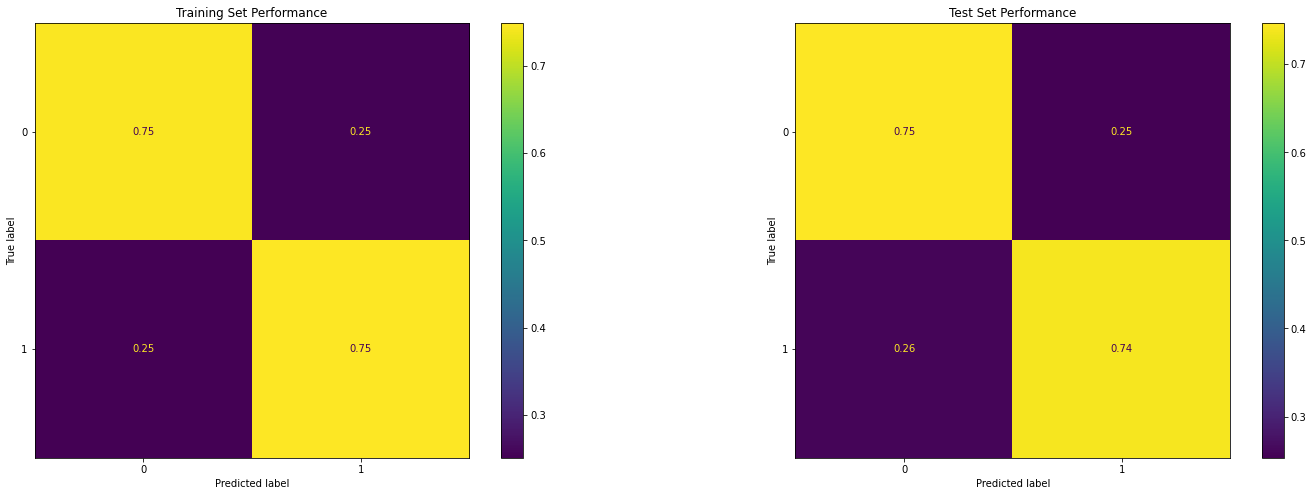

In [4]:
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train, Y_train)
eval_model(logistic_reg, X_train, Y_train, X_test, Y_test)

For python, using the LogisticRegression method from Sklearn, we need to calculate the p values ourselves. This code will do it for us

In [6]:
def p_values_regression(model, X):
  p = model.predict_proba(X)
  # if the intercept was not included, it will just be set to zero
  # so wont actually contribute to the P value calcs.
  n = len(p)
  m = len(model.coef_[0]) + 1
  coefs = np.concatenate([[model.intercept_[0]], model.coef_[0]])
  x_full = np.matrix(np.insert(np.array(X), 0, 1, axis = 1))
  ans = np.zeros((m, m))
  for i in range(n):
    ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
  vcov = np.linalg.inv(np.matrix(ans))
  se = np.sqrt(np.diag(vcov))
  t =  coefs/se  
  p = (1 - norm.cdf(abs(t))) * 2
  # now display the p values
  # display p value for intercept if used
  print('P values')
  if(model.intercept_[0] != 0):
    print('Intercept')
    print(p[0])
  # now print the P values for the covariates
  # the first element is for the intercept, even if it wasn't used in
  # the model, the P value will be found to be one
  print('Covariates')
  print(p[1:])


In [7]:
p_values_regression(logistic_reg, X_train)

P values
Intercept
0.9144919231644109
Covariates
[2.85396233e-01 2.17488881e-07 1.20579963e-01 5.38945894e-01
 5.72451055e-01 6.19994665e-03 1.31101550e-07 9.99391829e-01
 9.15671681e-01 3.80699359e-05 6.66133815e-16]


At this point we can proceed as we normally would, removing poor performing variables.

Test Accuracy: 0.74375
P values
Intercept
0.0
Covariates
[4.44847492e-10 3.05350501e-03 2.57044475e-09 9.17844948e-06
 0.00000000e+00]


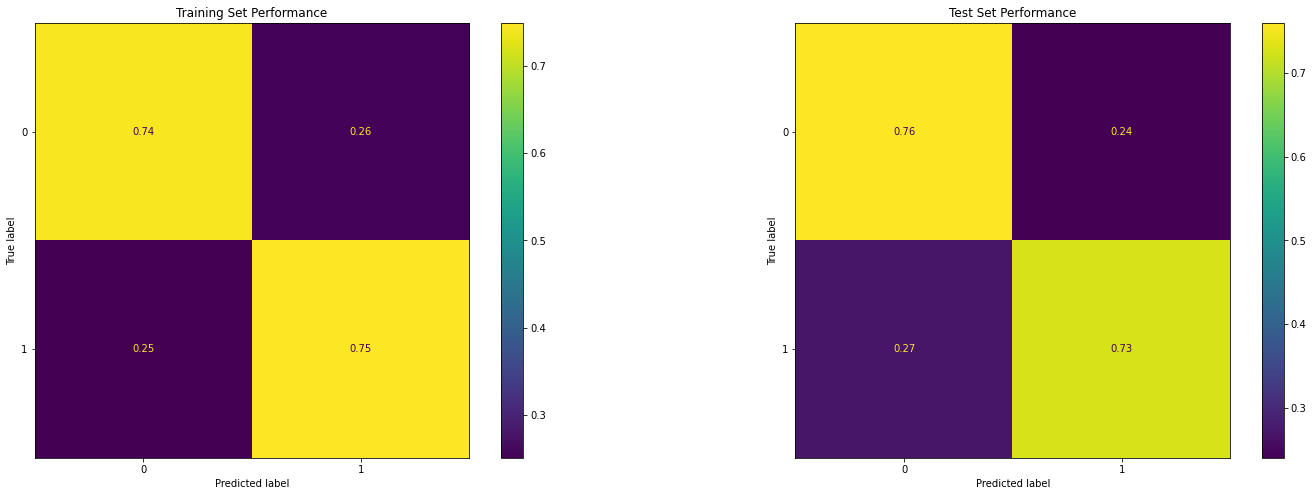

In [8]:
# Variables (using zero indexing) 1, 5 6 9 10 have P values < 0.05
# so lets keep these
X_train_2 = X_train.iloc[:, [1, 5, 6, 9, 10]]
X_test_2 = X_test.iloc[:, [1, 5, 6, 9, 10]]
logistic_reg = LogisticRegression(max_iter=1000)
logistic_reg.fit(X_train_2, Y_train)
eval_model(logistic_reg, X_train_2, Y_train, X_test_2, Y_test)
p_values_regression(logistic_reg, X_train_2)

Our cleaned up model looks ok, and doesn't seem to be overfitting, achieving very similar performance on the test set. 

Note that we haven't used a qqplot here, or other checks, but we could.

## SVMs
Let's try an SVM now. We'll start with the default settings.

Test Accuracy: 0.64375


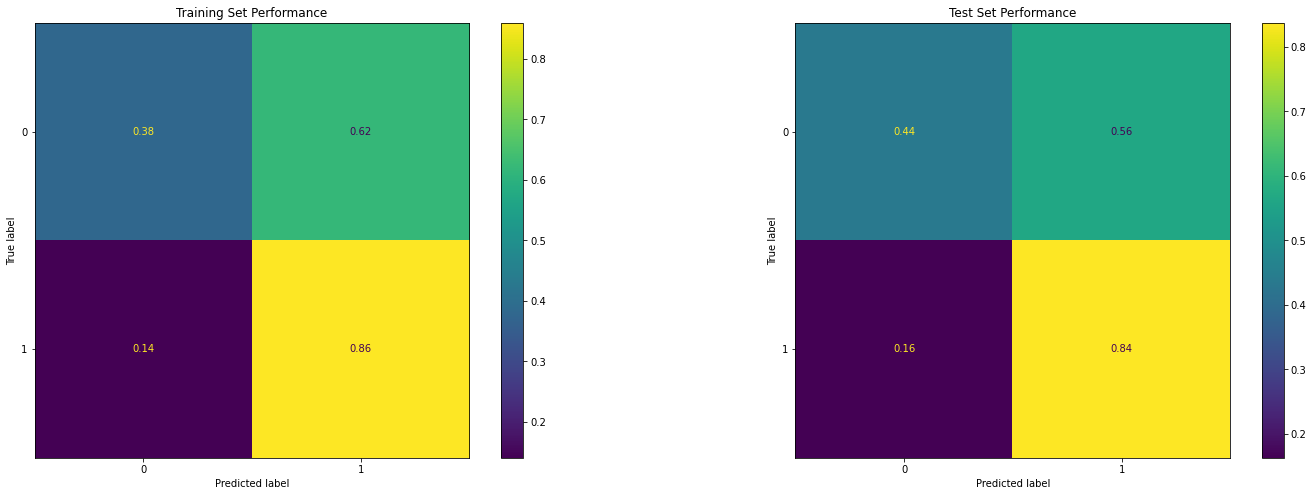

In [9]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

### Changing C
We'll try 5 values:
Hard-margin SVM (i.e. C = inf)
C=1000
C=10
C=0.1
C=0.001

#### Note:
Running this next bit of code is going to take a while. Good opporunity to go get a coffee.

We also see that we get some errors about convergence, i.e. our data may not actually be separable with some of those values of C.

Linear SVM, with C = inf


/home/ethan/cab420/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test Accuracy: 0.440625
Linear SVM, with C = 1000


/home/ethan/cab420/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test Accuracy: 0.446875
Linear SVM, with C = 10


/home/ethan/cab420/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Test Accuracy: 0.7375
Linear SVM, with C = 0.1
Test Accuracy: 0.721875
Linear SVM, with C = 0.001
Test Accuracy: 0.65625


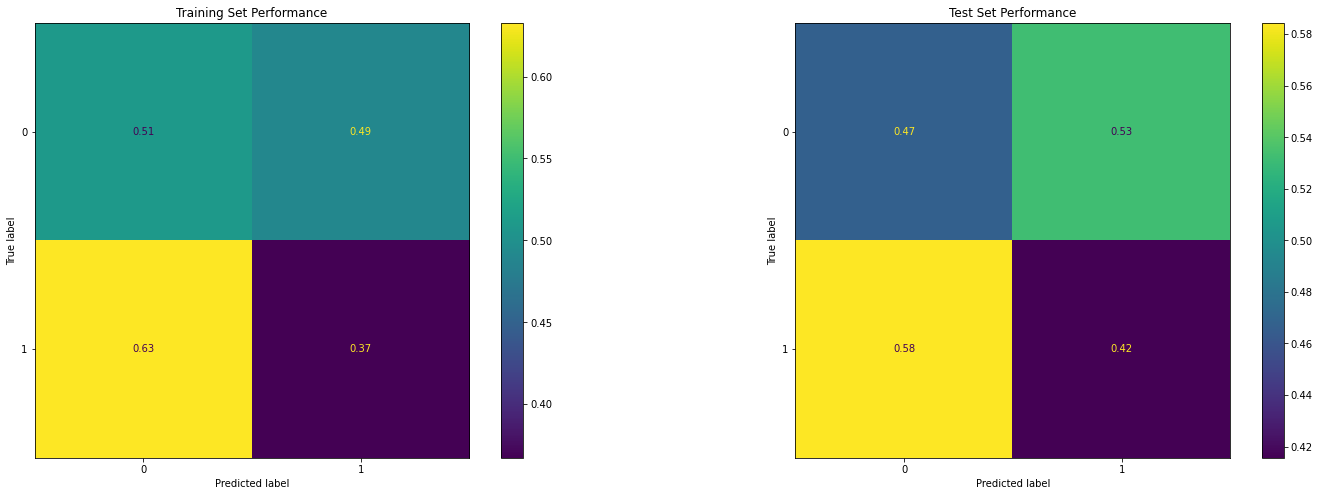

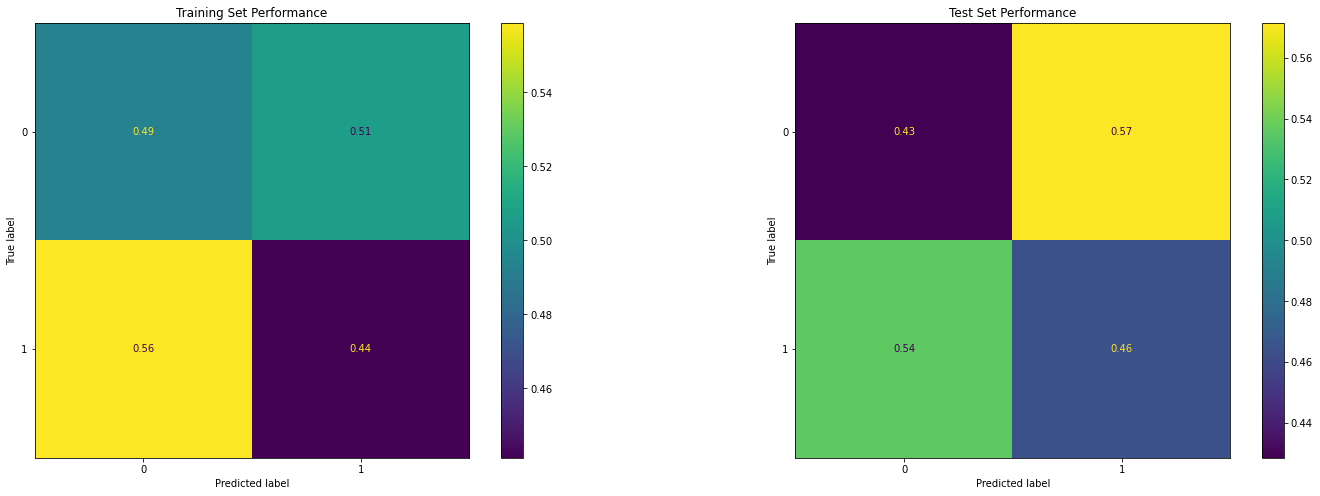

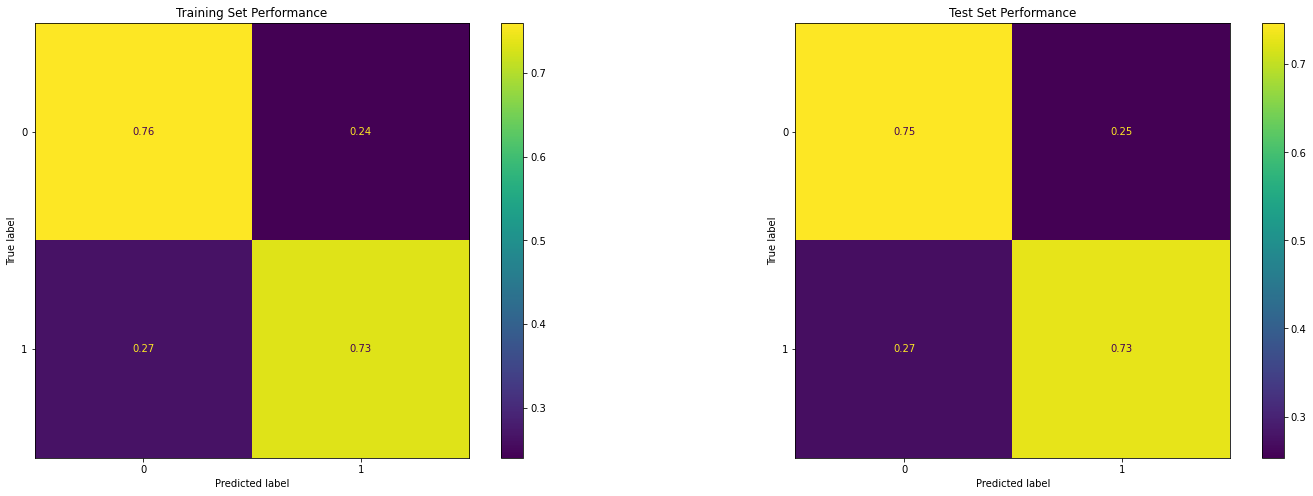

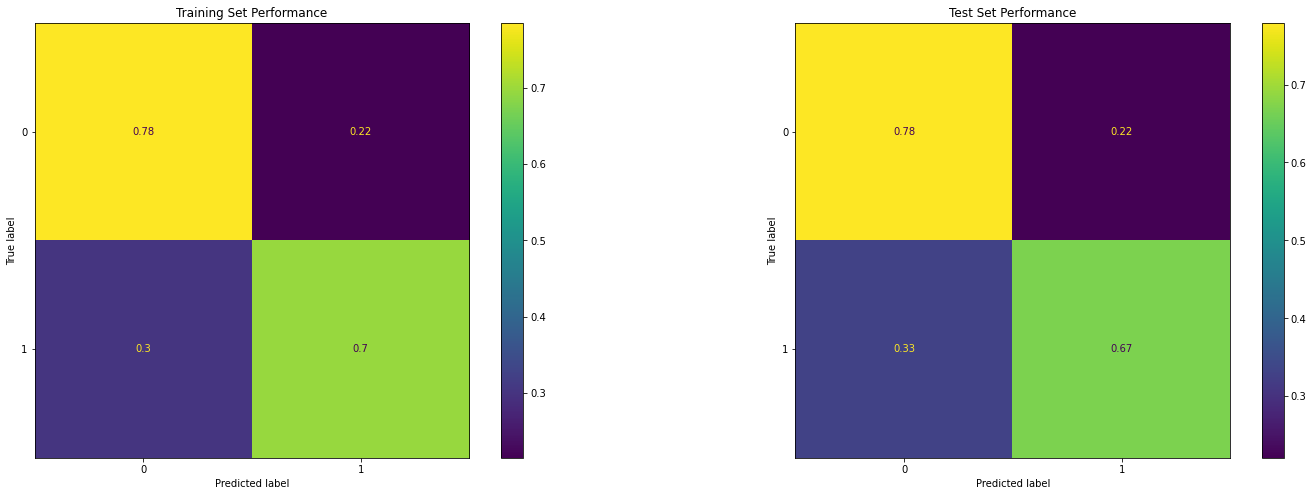

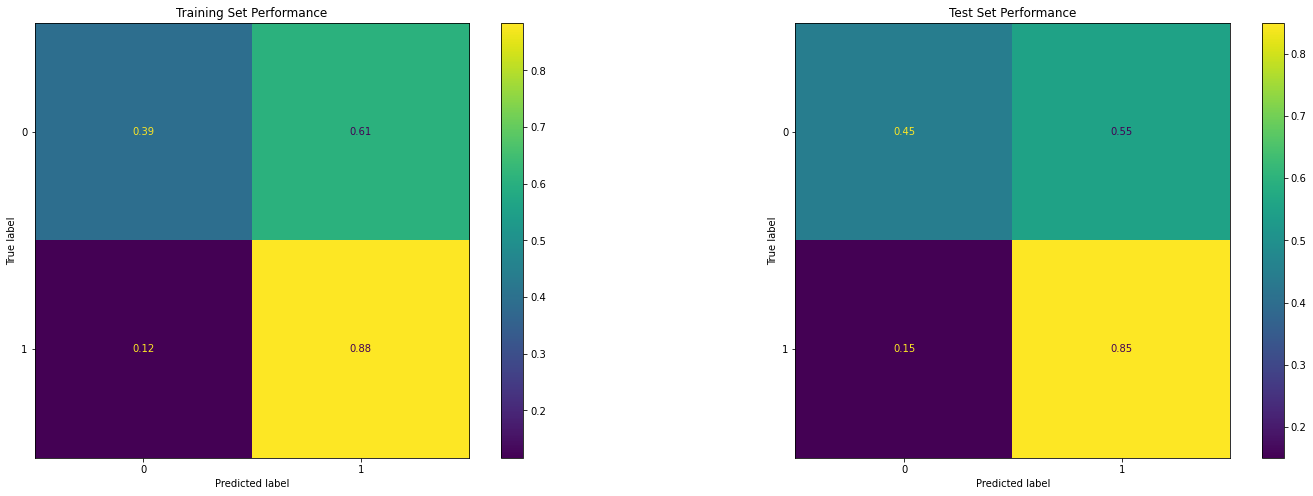

In [23]:

for C in [np.inf, 1000, 10, 0.1, 0.001]:
  print('Linear SVM, with C = {}'.format(C))
  svm = SVC(C=C, kernel='linear', max_iter=10e5)
  svm.fit(X_train, Y_train)
  eval_model(svm, X_train, Y_train, X_test, Y_test)

These models fail to converge, the data is not linearly separable, and so we need to relax the constraints somewhat.
Out middle three (10, 1, 0.1) values of C all obtain very similar performance

## Non Linear Kernels

We'll start by working with RBF (also called the squared exponential, or Gaussian Kernel).
We need to set the scale parameter. By default, SVC from SKLearn will set the scale to  `1 / (n_features * X.var())`.
To use this default, we set the `gamma` argument within the RBF kernel to be the string `'scale'`.
Otherwise we can set `gamma` to whatever we want to control the scale.

We'll try a few options.

RBF SVM, with scale = 10
Test Accuracy: 0.621875
RBF SVM, with scale = 100
Test Accuracy: 0.625
RBF SVM, with scale = 0.1
Test Accuracy: 0.734375
RBF SVM, with scale = scale
Test Accuracy: 0.64375


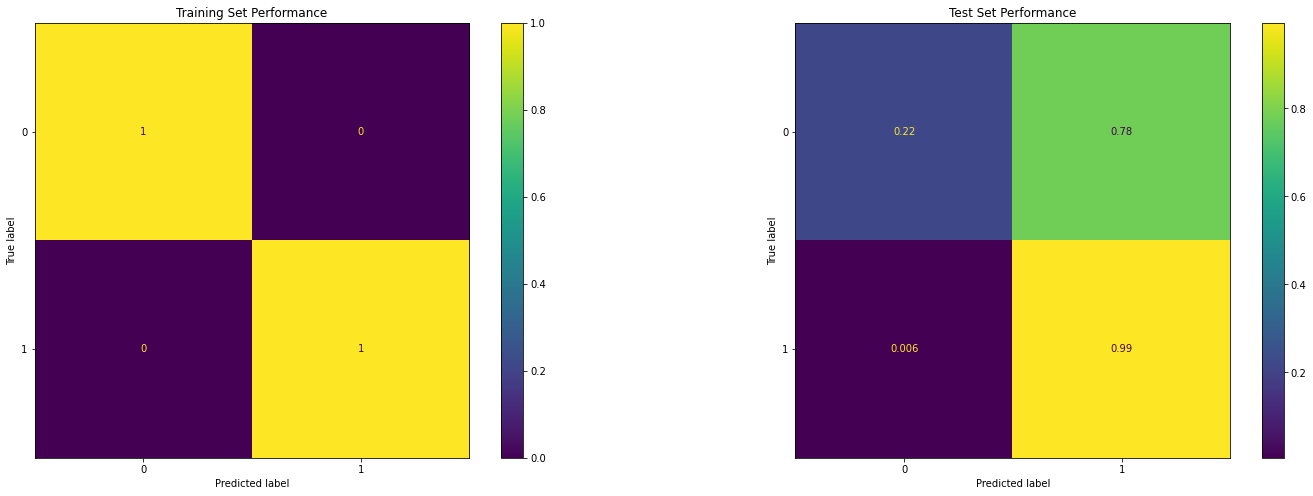

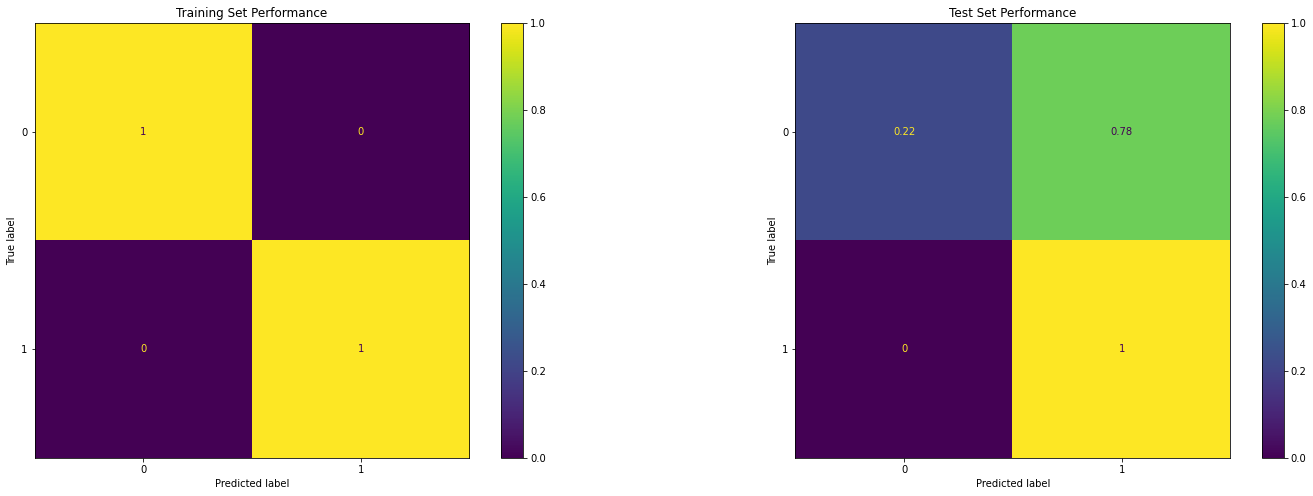

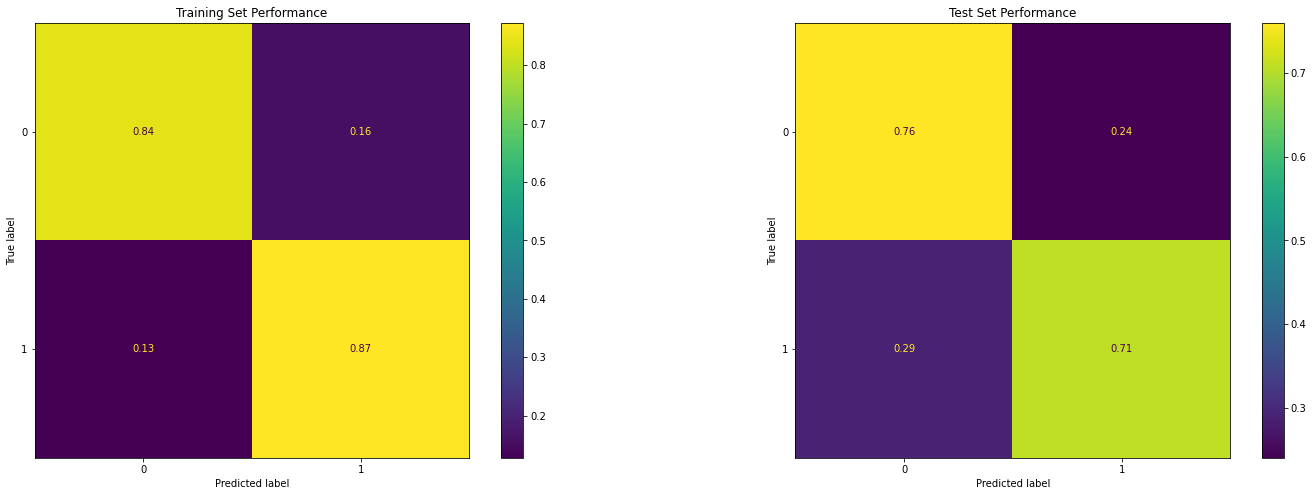

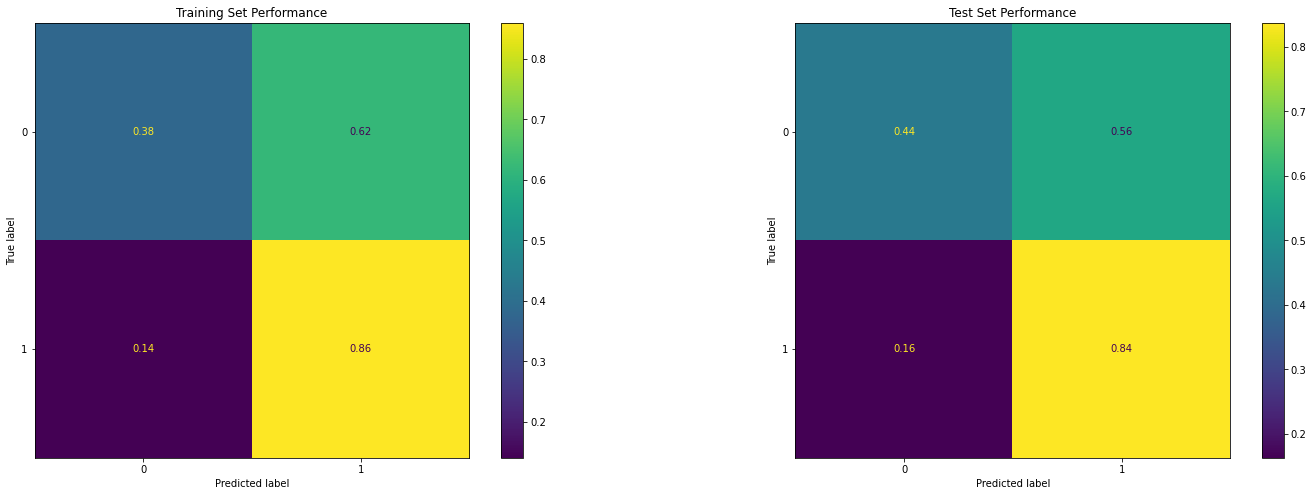

In [21]:
for kernel_scale in [10, 100, 0.1, 'scale']:
  print('RBF SVM, with scale = {}'.format(kernel_scale))
  svm = SVC(kernel='rbf', gamma=kernel_scale, max_iter=10e6)
  svm.fit(X_train, Y_train)
  eval_model(svm, X_train, Y_train, X_test, Y_test)

Trying Polynomial kernel now. Again, we'll try a bunch of different polynomial degrees. We can thing of higher degrees as just being more complex (i.e. more dimensions).

Polynomial Kernel SVM, with degree = 2
Test Accuracy: 0.63125
Polynomial Kernel SVM, with degree = 3
Test Accuracy: 0.646875
Polynomial Kernel SVM, with degree = 5
Test Accuracy: 0.65


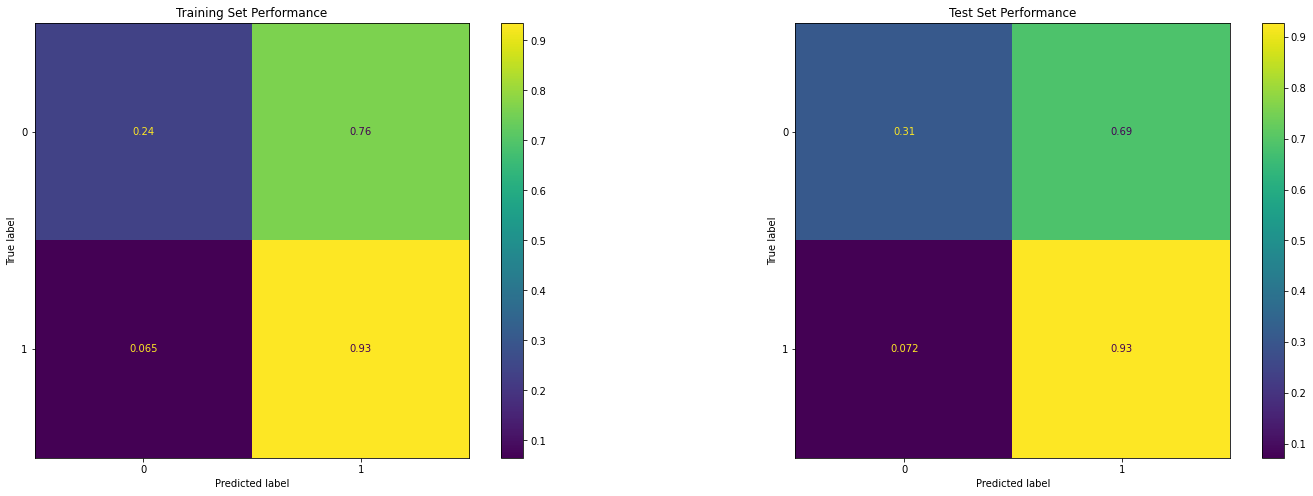

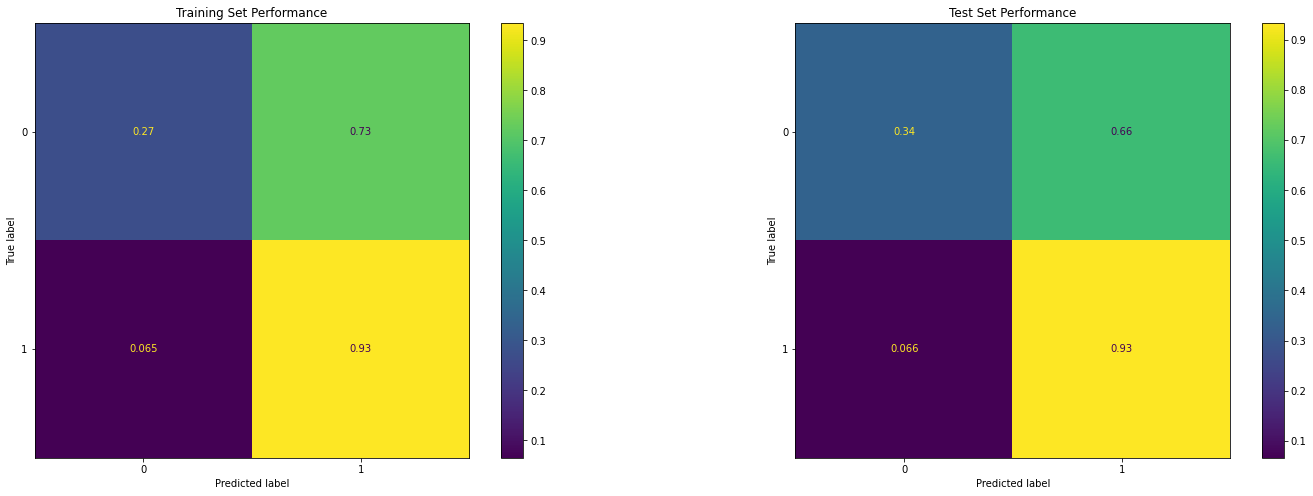

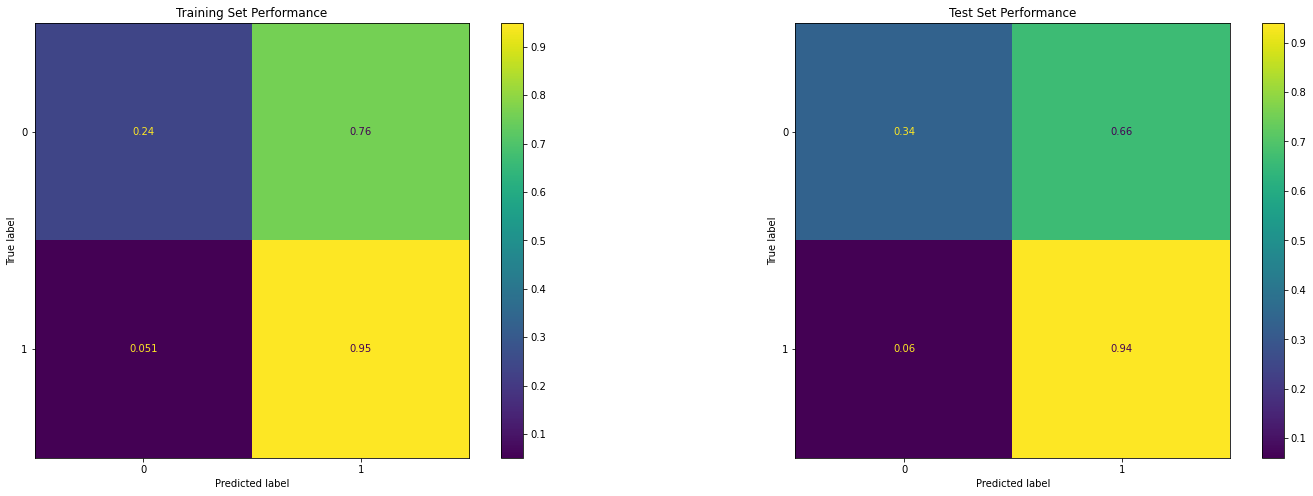

In [22]:
for degree in [2, 3, 5]:
  print('Polynomial Kernel SVM, with degree = {}'.format(degree))
  svm = SVC(kernel='poly', degree=degree, max_iter=10e6)
  svm.fit(X_train, Y_train)
  eval_model(svm, X_train, Y_train, X_test, Y_test)

We can see these aren't as good as our RBF kernels. Keep in mind though that we haven't considered different values of C here (or with the RBF kernels either), so there may exist a better solution that we haven't found. We could quite easily use a nested loop to search through multiple kernel parameters and values of C, and this would actually give us a grid search. This would be something worth exploring in your own time.